#### Goal: Dig deeper into the month with the highest number of trips (September) and visualize the area that had at least 25 or more trips. 

From my previous Uber trips visualization, September had the highest number of trips. 
http://rpubs.com/drucilal/564248

Import libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import os
os.environ['PROJ_LIB'] = '/Users/drucila/anaconda3/pkgs/proj4-5.0.1-h1de35cc_0/share/proj' 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import mplleaflet as mpl
%matplotlib inline
plt.plot([0,45], [0,45])
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from IPython.display import IFrame

Import September Uber Trips Dataset

In [2]:
uber = pd.read_csv('septuber.csv')
uber.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


Rename columns

In [3]:
uber.columns = ['timestamp', 'lat', 'lon', 'base']

Converting timestamps into Timestamp objects (pandas)

This may take a bit longer.

In [4]:
ti = time.time()

uber['timestamp'] = pd.to_datetime(uber['timestamp'])

tf = time.time()
print(tf-ti,' seconds.')

94.95693111419678  seconds.


Let's save this conversion incase we have to restart the kernel. 

In [5]:
uber.to_pickle('./test_data.pkl')
uber = pd.read_pickle('./test_data.pkl')

Extracting data from timestamp

In [6]:
uber['weekday'] = uber.timestamp.dt.weekday_name
uber['month'] = uber.timestamp.dt.month
uber['day'] = uber.timestamp.dt.day
uber['hour'] = uber.timestamp.dt.hour
uber['minute'] = uber.timestamp.dt.minute

In [7]:
day_map = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
uber['weekday'] = pd.Categorical(uber['weekday'], categories=day_map, ordered=True)

Trip Frequency by hour

In [8]:
## groupby operation
hourly_ride_data = uber.groupby(['day','hour','weekday'])['timestamp'].count()

## reset index
hourly_ride_data = hourly_ride_data.reset_index()

## rename column
hourly_ride_data = hourly_ride_data.rename(columns = {'timestamp':'ride_count'})

## ocular analysis
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Monday,699
1,1,1,Monday,490
2,1,2,Monday,363
3,1,3,Monday,333
4,1,4,Monday,261


In [9]:
max(hourly_ride_data['ride_count'])

3437

In [10]:
x= hourly_ride_data.query('weekday == "Saturday"')

In [11]:
x.query('ride_count > 3000')

,day,hour,weekday,ride_count
142,6,22,Saturday,3034
303,13,15,Saturday,3056
304,13,16,Saturday,3024
305,13,17,Saturday,3023
306,13,18,Saturday,3437
307,13,19,Saturday,3332


In [12]:
max(x['ride_count'])

3437

Looks like Saturdays had the highest numbers of trips.

In [13]:
## groupby operation
weekday_hourly_avg = hourly_ride_data.groupby(['weekday','hour'])['ride_count'].mean()

## reset index
weekday_hourly_avg = weekday_hourly_avg.reset_index()

## rename column
weekday_hourly_avg = weekday_hourly_avg.rename(columns = {'ride_count':'average_rides'})

## sort by categorical index
weekday_hourly_avg = weekday_hourly_avg.sort_index()

## ocular analysis
weekday_hourly_avg.head()

,weekday,hour,average_rides
0,Monday,0,377.0
1,Monday,1,240.2
2,Monday,2,195.4
3,Monday,3,356.0
4,Monday,4,495.8


Let's begin to visualize the locations of  the hot spots for uber drivers on a Saturday.

In [14]:
# Customized color palette
tableau_color_blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

for i in range(len(tableau_color_blind)):  
    r, g, b = tableau_color_blind[i]  
    tableau_color_blind[i] = (r / 255., g / 255., b / 255.)

Visualization of the average pick up rate vs hour of the day. 
Findings: Increase in trips on Friday and Saturday evening and night. 

Text(0.5, 0, 'Hour')

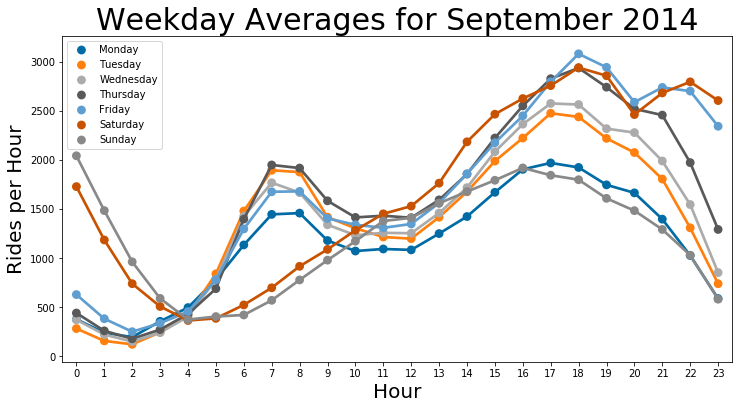

In [15]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='average_rides',hue='weekday', 
              palette = current_palette, data = weekday_hourly_avg)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Weekday Averages for September 2014', fontsize=30)
ax.set_ylabel('Rides per Hour', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

Below is a function inspired by https://www.kaggle.com/lambertosu/exploratory-analysis-with-density-based-clustering. 
Using the basemap package to categorize the results based on location, we will visualize our results through a heat map. 

In [16]:
def heat_map(ax_loc,title_str,rides_this_hour,nsew):
    
    ## get the axis
    ax = fig.add_subplot(ax_loc)

    ## make the basemap object
    m = Basemap(projection='merc', urcrnrlat=nsew[0], llcrnrlat=nsew[1],
                urcrnrlon=nsew[2], llcrnrlon=nsew[3], lat_ts=nsew[1], resolution='f')

    ## draw the background features
    m.drawmapboundary(fill_color = 'xkcd:light blue')
    m.fillcontinents(color='xkcd:grey', zorder = 1)
    m.drawcoastlines()
    m.drawrivers()

    ## project the GPS coordinates onto the x,y representation
    x, y = m(rides_this_hour['lon'].values, rides_this_hour['lat'].values)

    ## count the instances using the hexbin method and plot the results
    m.hexbin(x, y, gridsize=1000, mincnt = 1, bins = 'log', cmap=cm.YlOrRd, zorder = 2);

    ## set the title
    ax.set_title(title_str, fontsize=24)

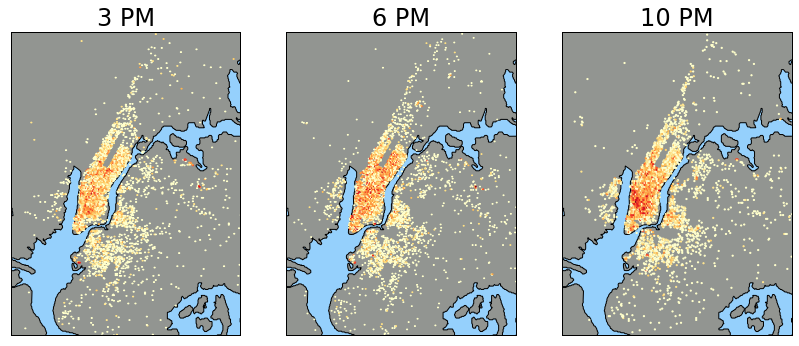

In [17]:
## set weekday for analysis: Saturday
target_day = 'Saturday'

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9, 40.6, -73.8, -74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## target hours
hrs = [15, 18, 22]

## axis subplot locations
ax_loc = [131, 132, 133] 

## title strings
title_str = ['3 PM', '6 PM', '10 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = uber.loc[(uber['weekday'] == target_day) & (uber['hour'] == hrs[ii])]

    ##  plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

In [18]:
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Monday,699
1,1,1,Monday,490
2,1,2,Monday,363
3,1,3,Monday,333
4,1,4,Monday,261


In [19]:
saturday_hourly_data = hourly_ride_data[hourly_ride_data['weekday']=='Saturday']

Text(0.5, 0, 'Hour')

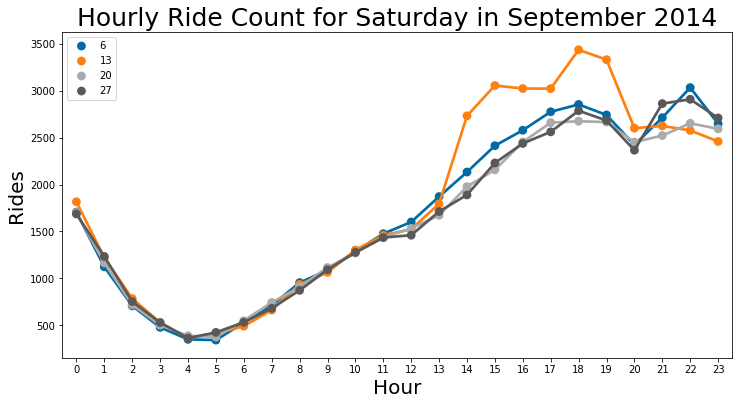

In [20]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='ride_count',hue='day', palette = current_palette, data = saturday_hourly_data)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Hourly Ride Count for Saturday in September 2014', fontsize=25)
ax.set_ylabel('Rides', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

Variation in afternoon through evening hours( 1-7 pm) September 6 and 13th.

Next Step: Comparison of these two days. 

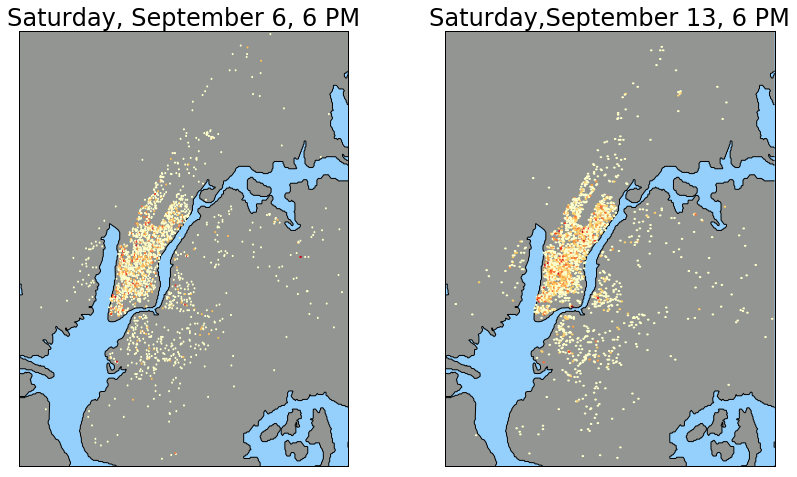

In [21]:
## set day for analysis
target_day = [6, 13]

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9,40.6,-73.8,-74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## hour 
hrs = 18

## axis locations
ax_loc = [121, 122] 

## title strings
title_str = ['Saturday, September 6, 6 PM', 'Saturday,September 13, 6 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = uber.loc[(uber['day'] == target_day[ii]) & (uber['hour'] == hrs)]

    ## plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

Largest Cluster: September 13th
Next: Let's look at these locations in more detail. 

In [22]:
## make the figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

## get ride data
rides_this_hour = uber.loc[(uber['day']== 13) & (uber['hour'] == 6) & (uber['minute'] < 16)]

## plot ride data
plt.plot(rides_this_hour['lon'], rides_this_hour['lat'], 'bo', markersize=4)

## display the Leaflet
# mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets

/Users/drucila/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [23]:
def get_hot_spots(max_distance,min_cars,ride_data):
    
    ## get coordinates from ride data
    coords = ride_data.as_matrix(columns=['lat', 'lon'])
    
    ## calculate epsilon parameter using
    ## the user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars,
                algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    ## group the clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    ## report
    print('Number of clusters: {}'.format(num_clusters))
    
    ## initialize lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):

        ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    hot_spots = [lon,lat,num_members]
    
    return hot_spots

In [24]:
# get ride data
ride_data = uber.loc[(uber['day']== 13) & (uber['hour'] > 15)]

## maximum distance between two cluster members in kilometers
max_distance = 0.05

## minimum number of cluster members
min_pickups = 25

## call the get_hot_spots function
hot_spots = get_hot_spots(max_distance ,min_pickups, ride_data)

/Users/drucila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Number of clusters: 59


In [28]:
%matplotlib inline
import mplleaflet as mpl
import matplotlib.pyplot as plt
## make the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

## set the color scale
color_scale = np.log(hot_spots[2])
# color_scale = hot_spots[2]

## make the scatter plot
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)

## display the Leaflet
#mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets


/Users/drucila/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Conclusion

Day: September 13, 2014, Hours: 3 pm to midnight 
Using this map, we visualized 59 locations which had at least 25 pickups.

Recommendation for Uber Drivers: Hot Spots to obtain more pick ups. 